In [42]:
import json
import os
import sys
import pathlib
from collections import defaultdict

import pymongo
import transformers
from tqdm import tqdm_notebook
from transformers import pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
import plotly.express as px
from binance.client import Client
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [43]:
PROJECT_ROOT = pathlib.Path.cwd().parent
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
print(PROJECT_ROOT)

/home/stanislav/Workspace/beautiful-creature


In [44]:
import project_settings
from project_settings import BINANCE_KEY, BINANCE_SECRET

In [45]:
name_mapping = {"Cardano": "ADAUSDT", "Ripple": "XRPUSDT", "Ethereum": "ETHUSDT", "Dogecoin": "DOGEUSDT",
                "Polkadot": "DOTUSDT", "Litecoin": "LTCUSDT", "Solana": "SOLUSDT",
                "VeChain": "VETUSDT", "FileCoin": "FILUSDT", "Monero": "XMRUSDT"}

symbol = "FILUSDT"

In [46]:
client = Client(BINANCE_KEY, BINANCE_SECRET)
klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY, start_str="1 Jan, 2021")
print("History size:", len(klines))

History size: 191


In [47]:
price = []
time = []
volume = []
for c in klines:
    time.append(datetime.datetime.fromtimestamp(int(str(c[0])[:-3])))
    price.append(float(c[4]))
    volume.append(float(c[5]))

hist_prices = pd.DataFrame({"time": time, "price": price, 'volume': volume})
hist_prices.head()
hist_prices = hist_prices.set_index("time")
hist_prices[hist_prices.columns] = StandardScaler().fit_transform(hist_prices)
hist_prices.index.name = "date"

Text(0.5, 1.0, 'FILUSDT')

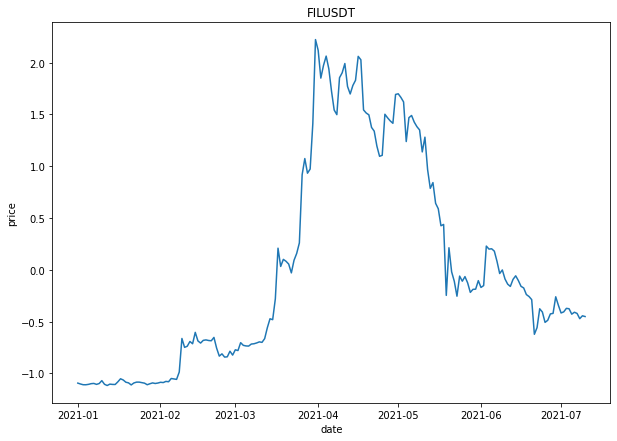

In [48]:
plt.figure(figsize=(10, 7))
sns.lineplot(x=hist_prices.index, y=hist_prices["price"])
plt.title(symbol)


In [49]:
def fetch_reddit_data(symbol: str):
    history_data_path = PROJECT_ROOT / "data" / 'reddit_crypto_stat.csv'
    df = pd.read_csv(history_data_path)
    df["keyword"] = df["keyword"].map(name_mapping)
    df = df.set_index(['keyword', 'date'])
    df = df.sort_index()
    sub_df = df.loc[symbol,:].copy()
    sub_df.loc[:,sub_df.columns] = StandardScaler().fit_transform(sub_df)
    sub_df.loc[:,sub_df.columns] = SimpleImputer().fit_transform(sub_df)
    sub_df.index = pd.to_datetime(sub_df.index, yearfirst=True)
    sub_df = sub_df.sort_index()
    return sub_df

def fetch_search_data(symbol: str):

    connection = pymongo.MongoClient(
        project_settings.MONGODB_SERVER,
        project_settings.MONGODB_PORT)
    google_trends_collection_name = f"{project_settings.MONGODB_GOOGLE_TRENDS_COLLECTION}_by_day"
    db = connection[project_settings.MONGODB_DB_NAME]
    google_trends_collection = db[google_trends_collection_name]
    data = google_trends_collection.find({})
    df = pd.DataFrame(data)
    df = df.drop("_id",axis=1)
    df = df.set_index("date")
    # df.index = pd.to_datetime(df.index, yearfirst=True)
    df[df.columns] = StandardScaler().fit_transform(df)
    df.columns = list(map(lambda x: name_mapping[x], df.columns))
    sub_df = df[[symbol]]
    sub_df.columns = ["search"]
    return sub_df

In [50]:
hist_reddit = fetch_reddit_data(symbol)

In [51]:
hist_search = fetch_search_data(symbol)

In [52]:
hist_prices = hist_prices.loc[hist_reddit.index[0]:]
hist_prices.index = pd.Series(hist_prices.index).apply(lambda x: datetime.datetime.combine(x.date(),datetime.datetime.min.time()))

In [53]:
merge_df = hist_reddit.join(hist_prices).join(hist_search)
for col in merge_df.columns:
    merge_df[col] = merge_df[col].rolling(5).mean()

In [54]:
px.defaults.width = 1000
px.defaults.height = 600
pd.options.plotting.backend = "plotly"

# merge_df = merge_df.reset_index()
merge_df.plot()